# Agent Navigation

---

Train an single DRL Unity ML-agent to navigate the [Banana Collector](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) environment.

---

You can download the environment matching your operation system from one of the following links:
* Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip)
* Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip)
* Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86.zip)
* Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86_64.zip)




## 1. Start the Environment

If necessary install following packages: **matplotlib**, **numpy**, **torch**, **unityagents**.


If needed uncoment the following cell and install **matplotlib**

In [1]:
import sys


# !{sys.executable} -m pip install matplotlib

If needed uncoment the following cell and install **numpy**

In [2]:
# !{sys.executable} -m pip install numpy

If needed uncoment the following cell and install **torch**. We will build the deep Q-Networks using torch.

In [3]:
#!{sys.executable} -m pip install torch

If needed uncoment the following cell and install **unityagents**. This package is needed to run the downloaded Unity Environment.

In [4]:
#!{sys.executable} -m pip install unityagents

Import the packages.

In [5]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  



**_Before running the code cell below_**, change the `bananaApp` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [6]:
file_path = '/home/ptrtmv/deep-reinforcement-learning/p1_navigation/Banana_Linux/'
bananaApp = file_path + 'Banana.x86_64'
env = UnityEnvironment(file_name=bananaApp,no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


The [Banana Collector](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) is in general a multi agent environment. Here we train a single agent.

In [7]:
# get the default environment brain
envBrainName = env.brain_names[0]
envBrain = env.brains[envBrainName]

## 2. Examine the State and Action Spaces

Before starting with the training let's examine the environment.

The simulation contains a single agent that navigates a large environment.  

At each time step, the agnet has four **actions** at its disposal:
    - walk forward 
    - walk backward
    - turn left
    - turn right

**The state space** has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  

**The rewards** are 

    `+1` for collecting a yellow banana
    `-1` for collecting a blue banana. 


In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[envBrainName]

# number of agents in the environment
print('Number of agents:\t', len(env_info.agents))

# number of actions
action_size = envBrain.vector_action_space_size
print('\nNumber of actions:\t', action_size)

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)
print('\nStates have length:\t', state_size)
print('\nStates look like:\n\n', state)

Number of agents:	 1

Number of actions:	 4

States have length:	 37

States look like:

 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]


## 3. Train your agent

First of all we need to import some dependencies and in particular the DrlAgent and DrlBrain classes. The later controlls the whole learning process parameters as well as the structure of the underlying Deep Q-Network. 

In [9]:
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from agent import DrlAgent, DrlBrain

Now we can define the training function: 

In [10]:
def trainAgent(nrEpisondes=1100, maxT=10000, epsStart=1, epsEnd=0.01, epsDecay=0.999):
    """
    Run training. 
    Args:
        nrEpisondes: 
            Number of episodes the training should last
        maxT:
            Max munber of steps during a single episode
        epsStart:
            Value of epsilon at the beginning of trainig.
        epsEnd:
            Value of epsilon at the end of trainig. (min value of epsilon)
        epsDecay:
            Decay of epsilon after each episode
    """
    
    print("Training started:\n")
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = epsStart/epsDecay            # initialize epsilon
    eps0 = epsStart
    
    for i_episode in range(1, nrEpisondes+1):
        
        env_info = env.reset(train_mode=True)[envBrainName]
        state = env_info.vector_observations[0]   # get the initial state
        
        eps = max(epsEnd, epsDecay*eps) # decrease epsilon
        
        if i_episode % 100 == 0:
            eps0 = eps
            print("\n")
        
        score = 0              
        for t in range(maxT):
            action = agent.act(state, eps)
                
            env_info = env.step(action)[envBrainName]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
                
            
            agent.experience(state, action, reward, next_state, done)
                
            if i_episode % 100 == 0:
                agent.saveTrainingStatus('checkpoint.pth')                
                
            state = next_state
            score += reward
            
            if done:
                break 
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:3.2f}\tLast Score: {:3.2f}\teps: {:1.4f} -> {:1.4f} '\
              .format(i_episode, np.mean(scores_window),score,eps0,eps), end="")   
                
    return scores


def plotScores(scores,meanOver = 100):
    """
    Plot the scores
    """
    yLimMin = -5
    scores = np.array(scores)
    
    runMean = np.convolve(scores, np.ones((meanOver,))/meanOver,mode='valid')[1:]

    mean13 = np.argwhere(runMean>13) + meanOver
    score13 = np.argwhere(scores>13)
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(meanOver,len(scores)), runMean)
    
    plt.plot([0, len(scores)],[13,13],'r')
    plt.plot([mean13[0],mean13[0]],[-5,13],'r')
    plt.text(mean13[0]-100,yLimMin+1,str(mean13[0]),color = 'r')
    
    #plt.scatter(score13,scores[score13],color='r')
    
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.xlim([0,len(scores)])
    plt.ylim([yLimMin,27])
    plt.show()


## Run the training for different agent configurations:

To approximate the state action value function we will use a deep Q-Network with `[64,32,16]` hidden layers. 

The (local) Q-network will be updated every `dqnUpdatePace = 5` steps using a batch gradient descent with learning rate `learningRate = 1e-4` and batch size `batchSize = 64`. 

The target network will be _softly_ updated with a parameter _Tau_ equal to `targetDqnUpdatePace = 5e-4`: 

    TARGET <--- (1-Tau) * TARGET + Tau * LOCAL

Training started:

Episode 99	Average Score: 0.95	Last Score: 2.00	eps: 1.0000 -> 0.0505  

Episode 199	Average Score: 4.08	Last Score: 5.00	eps: 0.0490 -> 0.0100  

Episode 299	Average Score: 5.50	Last Score: 9.00	eps: 0.0100 -> 0.0100  

Episode 399	Average Score: 6.95	Last Score: 11.00	eps: 0.0100 -> 0.0100 

Episode 499	Average Score: 9.73	Last Score: 17.00	eps: 0.0100 -> 0.0100 

Episode 599	Average Score: 11.36	Last Score: 10.00	eps: 0.0100 -> 0.0100 

Episode 699	Average Score: 12.64	Last Score: 10.00	eps: 0.0100 -> 0.0100 

Episode 799	Average Score: 12.55	Last Score: 17.00	eps: 0.0100 -> 0.0100 

Episode 899	Average Score: 12.18	Last Score: 9.00	eps: 0.0100 -> 0.0100  

Episode 999	Average Score: 14.41	Last Score: 18.00	eps: 0.0100 -> 0.0100 

Episode 1099	Average Score: 13.94	Last Score: 3.00	eps: 0.0100 -> 0.0100  

Episode 1100	Average Score: 13.90	Last Score: 10.00	eps: 0.0100 -> 0.0100 

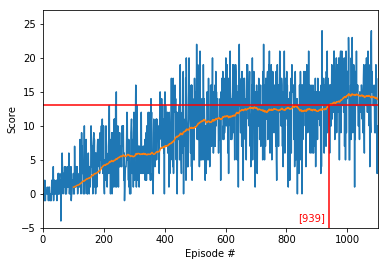

In [11]:
agentBrain = DrlBrain(stateSize=state_size, actionSize=action_size, 
             hiddenLayers=[64,32,16],
             gamma = 0.99,
             learningRate = 1e-4,     
             dropProb = .0,
             dqnUpdatePace = 5, 
             targetDqnUpdatePace = 5e-4,
             bufferSize = int(1e6),
             batchSize = 64,
             batchEpochs = 1,
             seed = 0)
 
agent = DrlAgent(agentBrain)

scores = trainAgent(epsStart=1, epsEnd=0.01, epsDecay=0.97)
plotScores(scores)   



   Instead of a _soft_ update, let us consider a _hard_ update of the target network after `targetDqnUpdatePace = 299` steps which corresponds to the length of a single episode. 
   
   I.e. the target network is not updated smoothly after each update of the local network, but is completely overwritten every `299` steps.

Training started:

Episode 99	Average Score: 4.37	Last Score: 1.00	eps: 1.0000 -> 0.0505  

Episode 199	Average Score: 9.07	Last Score: 14.00	eps: 0.0490 -> 0.0100 

Episode 299	Average Score: 11.96	Last Score: 13.00	eps: 0.0100 -> 0.0100 

Episode 399	Average Score: 11.36	Last Score: 12.00	eps: 0.0100 -> 0.0100 

Episode 499	Average Score: 12.08	Last Score: 18.00	eps: 0.0100 -> 0.0100 

Episode 599	Average Score: 14.05	Last Score: 10.00	eps: 0.0100 -> 0.0100 

Episode 699	Average Score: 14.56	Last Score: 14.00	eps: 0.0100 -> 0.0100 

Episode 799	Average Score: 13.56	Last Score: 13.00	eps: 0.0100 -> 0.0100 

Episode 899	Average Score: 15.30	Last Score: 16.00	eps: 0.0100 -> 0.0100 

Episode 999	Average Score: 15.02	Last Score: 6.00	eps: 0.0100 -> 0.0100  

Episode 1099	Average Score: 15.78	Last Score: 15.00	eps: 0.0100 -> 0.0100 

Episode 1100	Average Score: 15.79	Last Score: 17.00	eps: 0.0100 -> 0.0100 

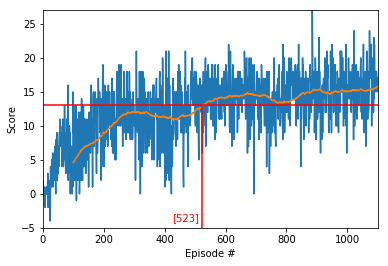

In [12]:
agentBrain = DrlBrain(stateSize=state_size, actionSize=action_size, 
             hiddenLayers=[64,32,16],
             gamma = 0.99,
             learningRate = 1e-4,     
             dropProb = .0,
             dqnUpdatePace = 5, 
             targetDqnUpdatePace = 299,  
             bufferSize = int(1e6),
             batchSize = 64,
             batchEpochs = 1, 
             seed = 0)
 
agent = DrlAgent(agentBrain)

scores = trainAgent(epsStart=1, epsEnd=0.01, epsDecay=0.97)
plotScores(scores)   

Until now the local network was updated every `dqnUpdatePace = 5` steps using a batch gradient descent (batch size of `batchSize = 64`) with a single _gradient step_ (single epoch). 

Let us now use a batch gradient descent of the same batch size but instead of making a single _gradient step_ each time the network is updated we will make `batchEpochs = 5` steps. I.e. we will run each time the gradient descent for five epochs.

Training started:

Episode 99	Average Score: 2.27	Last Score: 13.00	eps: 1.0000 -> 0.0505  

Episode 199	Average Score: 8.41	Last Score: 16.00	eps: 0.0490 -> 0.0100 

Episode 299	Average Score: 13.95	Last Score: 11.00	eps: 0.0100 -> 0.0100 

Episode 399	Average Score: 14.55	Last Score: 20.00	eps: 0.0100 -> 0.0100 

Episode 499	Average Score: 15.32	Last Score: 18.00	eps: 0.0100 -> 0.0100 

Episode 599	Average Score: 14.53	Last Score: 16.00	eps: 0.0100 -> 0.0100 

Episode 699	Average Score: 14.46	Last Score: 14.00	eps: 0.0100 -> 0.0100 

Episode 799	Average Score: 16.08	Last Score: 12.00	eps: 0.0100 -> 0.0100 

Episode 899	Average Score: 16.39	Last Score: 22.00	eps: 0.0100 -> 0.0100 

Episode 999	Average Score: 15.78	Last Score: 14.00	eps: 0.0100 -> 0.0100 

Episode 1099	Average Score: 15.90	Last Score: 18.00	eps: 0.0100 -> 0.0100 

Episode 1100	Average Score: 15.92	Last Score: 16.00	eps: 0.0100 -> 0.0100 

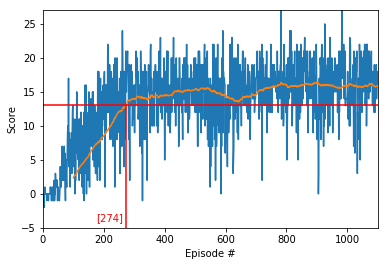

In [13]:
agentBrain = DrlBrain(stateSize=state_size, actionSize=action_size, 
             hiddenLayers=[64,32,16],
             gamma = 0.99,
             learningRate = 1e-4,     
             dropProb = .0,
             dqnUpdatePace = 5, 
             targetDqnUpdatePace = 299, 
             bufferSize = int(1e6),
             batchSize = 64,
             batchEpochs = 5, 
             seed = 0)
 
agent = DrlAgent(agentBrain)

scores = trainAgent(epsStart=1, epsEnd=0.01, epsDecay=0.97)
plotScores(scores)   

To deal with potential overfitting (enhanced by the higher number of epochs) we can introduce drop-out regularization with  a drop-out probability of `dropProb = 0.1`.

Training started:

Episode 99	Average Score: 4.37	Last Score: 13.00	eps: 1.0000 -> 0.0505  

Episode 199	Average Score: 13.30	Last Score: 13.00	eps: 0.0490 -> 0.0100 

Episode 299	Average Score: 14.31	Last Score: 16.00	eps: 0.0100 -> 0.0100 

Episode 399	Average Score: 14.94	Last Score: 16.00	eps: 0.0100 -> 0.0100 

Episode 499	Average Score: 14.22	Last Score: 17.00	eps: 0.0100 -> 0.0100 

Episode 599	Average Score: 14.23	Last Score: 15.00	eps: 0.0100 -> 0.0100 

Episode 699	Average Score: 12.80	Last Score: 9.00	eps: 0.0100 -> 0.0100  

Episode 799	Average Score: 12.33	Last Score: 2.00	eps: 0.0100 -> 0.0100  

Episode 899	Average Score: 10.54	Last Score: 16.00	eps: 0.0100 -> 0.0100 

Episode 999	Average Score: 9.16	Last Score: 14.00	eps: 0.0100 -> 0.0100  

Episode 1099	Average Score: 10.59	Last Score: 20.00	eps: 0.0100 -> 0.0100 

Episode 1100	Average Score: 10.48	Last Score: 4.00	eps: 0.0100 -> 0.0100 

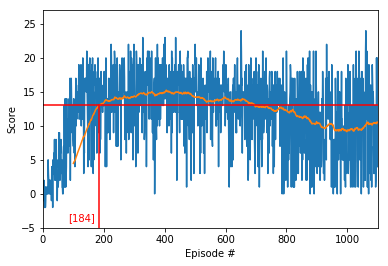

In [15]:
agentBrain = DrlBrain(stateSize=state_size, actionSize=action_size, 
             hiddenLayers=[64,32,16],
             gamma = 0.99,
             learningRate = 1e-4,     
             dropProb = 0.1, 
             dqnUpdatePace = 5, 
             targetDqnUpdatePace = 299, 
             bufferSize = int(1e6),
             batchSize = 64,
             batchEpochs = 5, 
             seed = 0)
 
agent = DrlAgent(agentBrain)

scores = trainAgent(epsStart=1, epsEnd=0.01, epsDecay=0.97)
plotScores(scores)   